This notebook is my attempt to make the community overview plot separated by aspiration status

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
%matplotlib inline

In [2]:
import os, sys
src_dir = os.path.normpath(os.path.join(os.getcwd(), '../util'))
sys.path.append(src_dir)
import util


/Users/claire/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
fnotu = '/Users/claire/github/aspiration-analysis/data/clean/rosen.otu_table.rel_abun.clean'
fnmeta = '/Users/claire/github/aspiration-analysis/data/clean/rosen.metadata.clean'

meta = pd.read_csv(fnmeta, sep='\t', index_col=0)
df = pd.read_csv(fnotu, sep='\t', index_col=0)

In [4]:
df = util.collapse_taxonomic_contents_df(df, 'genus', keep_unanno=True)

In [5]:
# Keep just patients with all 3 sites sequenced
aero_sites = ['bal', 'gastric_fluid', 'throat_swab']

meta['mbs_consolidated'] = meta['mbs_consolidated'].fillna('nan')

meta = meta[~(  meta['sample_id.1'].str.endswith('2')
              | meta['sample_id.1'].str.endswith('F')
              | meta['sample_id.1'].str.endswith('F2T')
              | meta['sample_id.1'].str.startswith('05'))]

patientsamples = meta\
    .groupby(['mbs_consolidated', 'site', 'subject_id'])\
    .size()\
    .to_frame('n_samples')\
    .reset_index()

subjects = patientsamples\
            .query('(site == @aero_sites)')\
            .groupby(['mbs_consolidated', 'subject_id'])\
            .size()

In [6]:
subjects = subjects[subjects == 3].reset_index()['subject_id'].unique().tolist()

# Subset metadata and OTU table
meta = meta.query('subject_id == @subjects').sort_values(by=['subject_id', 'site'])
df = df.loc[meta.index]
print(meta.shape, df.shape)

((198, 958), (198, 240))


In [7]:
## Set up colormap for plotting
def get_phylo_colors(otus):
    """
    Return the df with phylum and orders. Make color_dict to plot bar phylogeny.

    Parameters
    ----------
    otus : list or numpy array
        list of OTUs to return colors for. Should be the full taxonomy
        (starting with k__;...) and in the order that you'll want to plot them.
        
    Return
    ------
    phylodf : pandas DataFrame
        dataframe with 'phylum', 'class', 'order', etc columns, in the same
        order is in keep_rows. Values are text like ('o__Clostridiales')
    color_dict : dict
        dictionary with {tax_level: RGBA tuple}, where tax_level
        is a string like 'o__Clostridiales'. All phyla and genera
        in otus are in this dict.
    """
    phylodf = pd.DataFrame(otus, columns=['full'])
    # Split full taxonomy into sub-taxa
    phylodf = phylodf['full'].str.split(';', expand=True)
    newcols = ['kingdom', 'phylum', 'class', 'order', 
               'family', 'genus', 'species', 'denovo']
    phylodf.columns = newcols[:len(phylodf.columns)]
    phylodf['otu'] = otus
    
    # If genus is 'g__Other', add the phylum designation to the g__Other string
    phylodf['genus'] = phylodf.apply(lambda row: row['phylum'] + ';' + row['genus'] 
                                     if row['genus'] == 'g__Other'
                                     else row['genus'],
                                     axis=1)
    
    ## Set1 color palette
    colors = sns.color_palette('Set1', 9)
    
    ## Manually set the Set1 index for each phylum
    # red (proteo), blue (bacteroides), green (actino), purple (firmicutes),
    # orange (fuso), yellow, brown (eury), pink (verruco),
    # pink (teneri, cyano, lenti, synerg), gray (p__)
    # this color dict is for 'Set1' color palette
    color_dict = {'p__Acidobacteria': 7,
                  'p__Actinobacteria': 2,
                  'p__Bacteroidetes': 1,
                  'p__Candidatus_Saccharibacteria': 7,
                  'p__Chlamydiae': 7,
                  'p__Cyanobacteria/Chloroplast': 7,
                  'p__Euryarchaeota': 7,
                  'p__Firmicutes': 3,
                  'p__Fusobacteria': 4,
                  'p__Proteobacteria': 0,
                  'p__SR1': 7,
                  'p__Spirochaetes': 7,
                  'p__Tenericutes': 7,
                  'p__Verrucomicrobia': 7,
                  'p__': 8}

    # Convert Set1 index to its corresponding RGB value
    color_dict = {i: colors[color_dict[i]] for i in color_dict}

    ## Check that all phyla in phylodf have a color
    missingphyla = [i for i in phylodf['phylum'].unique()
                    if i not in color_dict]
    if len(missingphyla) > 0:
        print('You need to give the following phyla colors in get_phylo_colors():')
        print('\n'.join(missingphyla))
        raise ValueError

    ## Give each genus a shade of the phylum color
    for p, subdf in phylodf.groupby('phylum'):
        # Get unique genera in that phylum (pandas unique() returns values in order of appearance)
        genera = subdf['genus'].unique()

        # Seed a light palette from the top-level phylum color.
        genus_colors = sns.light_palette(color_dict[p], len(genera) + 2)[1:-1]
        # Assign corresponding index in `colors` to each genus,
        # and add to the master color_dict
        color_dict.update(
            {genera[i]: genus_colors[i] for i in range(len(genera))})

    return phylodf, color_dict

In [8]:
# Get the dataframe with the phylogeny
phylodf, _ = get_phylo_colors(df.columns)

In [9]:
# Rename any genera with less than 1% mean abundance overall as "Other"
abun_thresh = 0.01

# Add abundance to tidy phylodf
abun_otus = df.mean()
phylodf['abun'] = phylodf['otu'].apply(lambda x: abun_otus[x])

# Functions to rename unlabeled and low-abundant genera as g__Other
def otu2other(row, abun_thresh):
    if not row['otu'].endswith('__') and row['abun'] > abun_thresh:
        return row['otu']
    else:
        return row['otu'].rsplit(';', 1)[0] + ';g__Other'

def genus2other(row, abun_thresh):
    if not row['genus'].endswith('__') and row['abun'] > abun_thresh:
        return row['genus']
    else:
        return row['phylum'] + ';g__Other'

phylodf['otu2'] = phylodf.apply(lambda row: otu2other(row, abun_thresh), axis=1)
phylodf['genus2'] = phylodf.apply(lambda row: genus2other(row, abun_thresh), axis=1)

# Get colors for 'otu2', which has the 'g__Other' label
_, color_dict = get_phylo_colors(phylodf['otu2'].values)

In [10]:
## Nope, not doing this anymore... commenting out related lines for now
### Order samples by descending order of most abundant genus in lung samples

## Get mean abundance of each OTU in the lung samples
#lung_samples = meta.query('site == "bal"').index
#abun_otus = df.loc[lung_samples].median() 

# Set up manual ordering for phyla
phy_order = ['p__Firmicutes',
             'p__Proteobacteria',
             'p__Bacteroidetes',
             'p__Actinobacteria',
             'p__Fusobacteria',
             'p__Cyanobacteria/Chloroplast',
             'p__Verrucomicrobia',
             'p__SR1',
             'p__Spirochaetes',
             'p__Candidatus_Saccharibacteria',
             'p__Tenericutes',
             'p__Chlamydiae',
             'p__Acidobacteria',
             'p__Euryarchaeota']
phylodf['phylum'] = phylodf['phylum'].astype("category")
phylodf['phylum'].cat.set_categories(phy_order, inplace=True)

## Sort OTUs by abundance in the lungs, within each phylum
#phylodf['abun'] = phylodf['otu'].apply(lambda x: abun_otus[x])
#phylodf = phylodf.sort_values(by=['phylum', 'abun'], ascending=[False, True])
phylodf = phylodf.sort_values(by=['phylum', 'abun'], ascending=[False, True])

# Get colors for 'otu2', which has 'g__Other' label
_, color_dict = get_phylo_colors(phylodf['otu2'].values)

## Need to reverse the ordering so more abundant are on bottom
phylodf = phylodf.sort_values(by=['phylum', 'abun'], ascending=[False, False])

# Update colors with new ordering
phylodf['color'] = phylodf['genus2'].apply(lambda x: color_dict[x])

# Re-order OTU table columns accordingly
df = df[phylodf['otu']]

# Re-order rows by their abundance in each column
df = df.sort_values(by=df.columns.tolist(), ascending=False)

In [11]:
## Get the subjects for each aspiration type and order all samples the same
asp = "Aspiration/Penetration"
nml = "Normal"

lung_samples = df.index.tolist()
lung_samples = [s for s in lung_samples if meta.loc[s, 'site'] == "bal"]

patients = [meta.loc[s, 'subject_id'] for s in lung_samples]

# Get the three subgroups of patients. We'll keep these as separate lists
# because even though it's annoying, it's actually best for interpretation
asp_pts = meta.query('(subject_id == @patients) & (mbs_consolidated == @asp)')['subject_id'].drop_duplicates().tolist()
nml_pts = meta.query('(subject_id == @patients) & (mbs_consolidated == @nml)')['subject_id'].drop_duplicates().tolist()
nan_pts = meta.query('(subject_id == @patients) & (mbs_consolidated == "nan")')['subject_id'].drop_duplicates().tolist()

bal_asp = [meta.query('(subject_id == @s) & (site == "bal")').index[0] for s in asp_pts]
bal_nml = [meta.query('(subject_id == @s) & (site == "bal")').index[0] for s in nml_pts]
bal_nan = [meta.query('(subject_id == @s) & (site == "bal")').index[0] for s in nan_pts]

gas_asp = [meta.query('(subject_id == @s) & (site == "gastric_fluid")').index[0] for s in asp_pts]
gas_nml = [meta.query('(subject_id == @s) & (site == "gastric_fluid")').index[0] for s in nml_pts]
gas_nan = [meta.query('(subject_id == @s) & (site == "gastric_fluid")').index[0] for s in nan_pts]

thr_asp = [meta.query('(subject_id == @s) & (site == "throat_swab")').index[0] for s in asp_pts]
thr_nml = [meta.query('(subject_id == @s) & (site == "throat_swab")').index[0] for s in nml_pts]
thr_nan = [meta.query('(subject_id == @s) & (site == "throat_swab")').index[0] for s in nan_pts]

In [12]:
# Sanity check: patients should be in the same order
print(meta.query('subject_id == @asp_pts')['mbs_consolidated'].unique())
print(', '.join(asp_pts[0:10]))
print(', '.join(bal_asp[0:10]))
print(', '.join(gas_asp[0:10]))
print(', '.join(thr_asp[0:10]))

print(meta.query('subject_id == @nml_pts')['mbs_consolidated'].unique())
print(', '.join(nml_pts[0:10]))
print(', '.join(bal_nml[0:10]))
print(', '.join(gas_nml[0:10]))
print(', '.join(thr_nml[0:10]))

print(meta.query('subject_id == @nan_pts')['mbs_consolidated'].unique())
print(', '.join(nan_pts[0:10]))
print(', '.join(bal_nan[0:10]))
print(', '.join(gas_nan[0:10]))
print(', '.join(thr_nan[0:10]))

['Aspiration/Penetration']
03-121-5, 03-124-8, 04-054-3, 04-064-5, 04-072-1, 04-077-1, 04-112-4, 04-133-5, 04-138-4, 04-139-5
03-121-5B, 03-124-8B, 04-054-3B, 04-064-5B, 04-072-1B, 04-077-1B, 04-112-4B, 04-133-5B, 04-138-4B, 04-139-5B
03-121-5G, 03-124-8G, 04-054-3G, 04-064-5G, 04-072-1G, 04-077-1G, 04-112-4G, 04-133-5G, 04-138-4G, 04-139-5G
03-121-5T, 03-124-8T, 04-054-3T, 04-064-5T, 04-072-1T, 04-077-1T, 04-112-4T, 04-133-5T, 04-138-4T, 04-139-5T
['Normal']
02-098-5, 02-120-4, 03-105-2, 03-122-5, 03-123-6, 04-061-8, 04-063-7, 04-066-0, 04-071-9, 04-074-1
02-098-5B, 02-120-4B, 03-105-2B, 03-122-5B, 03-123-6B, 04-061-8B, 04-063-7B, 04-066-0B, 04-071-9B, 04-074-1B
02-098-5G, 02-120-4G, 03-105-2G, 03-122-5G, 03-123-6G, 04-061-8G, 04-063-7G, 04-066-0G, 04-071-9G, 04-074-1G
02-098-5T, 02-120-4T, 03-105-2T, 03-122-5T, 03-123-6T, 04-061-8T, 04-063-7T, 04-066-0T, 04-071-9T, 04-074-1T
['nan']
02-099-7, 02-118-7, 03-108-5, 03-112-5, 03-113-4, 03-119-5, 03-137-6, 04-062-8, 04-067-2, 04-075-8
02-

[19, 23, 24]


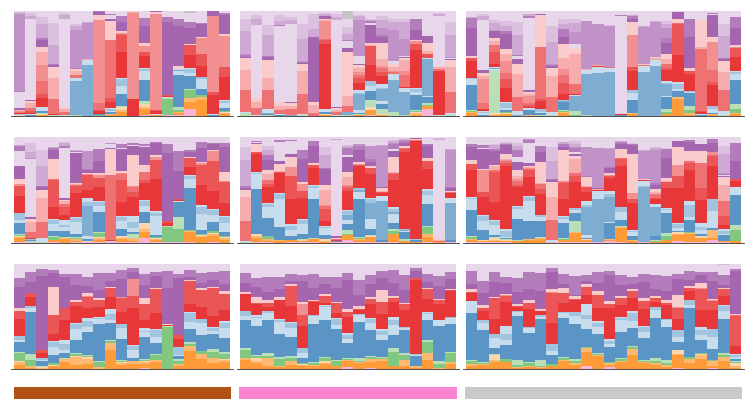

In [13]:
## Stacked bar plot of all three sitse

# Number of patients to plot
#N = [5, 7, 10]
N = [len(nml_pts), len(asp_pts), len(nan_pts)]
print(N)

# Set up aspiration colors
aspdict = {'Normal': '#B25116', 'Aspiration/Penetration': '#FB84D1', 'nan': '#C9C9C9'}
asplst = ['Normal', 'Aspiration/Penetration', 'nan']

## Set up figure
fig = plt.figure(figsize=(14, 6))
sns.set_style('white')

# One gridspec on top with 3 subplots (stacked barplots)
gs_plots = gridspec.GridSpec(3, sum(N), top=0.95, bottom=0.12, wspace=0.5)
# One on bottom with 1 subplot (aspiration status)
gs_asp = gridspec.GridSpec(1, sum(N), top=0.08, bottom=0.05)

# Set up the samples I'm going to plot
smpls = {'Lung (BAL)': [bal_asp, bal_nml, bal_nan],
         'Gastric fluid': [gas_asp, gas_nml, gas_nan], 
         'Oropharyngeal swab': [thr_asp, thr_nml, thr_nan]}
i = 0
site_names = ['Lung (BAL)', 'Gastric fluid', 'Oropharyngeal swab']
for name in site_names:
    # a is the index of [asp, nml, nan]
    # order is hard-coded in asplst and N above - these need to match!
    start_idx = 0
    for a in [0, 1, 2]:
        ## Plot phylogeny bar plots
        smpl_lst = smpls[name][a][:N[a]]
        #print(name, a, len(lst))
        #print(', '.join(lst))
        ax = plt.subplot(gs_plots[i, start_idx:start_idx+len(smpl_lst)])
        # Stacked bar plot from df with samples in rows, OTUs in columns
        df.loc[smpl_lst].plot(ax=ax, kind='bar', stacked=True,
                         color=phylodf['color'], legend=False,
                         width=1.0, edgecolor="none")

        ax.set_ylim([0, 1])
        ax.set_yticklabels('')
        ax.set_xticklabels('')
        sns.despine(ax=ax, left=True)
        #ax.set_title(name)
        
        ## Plot aspiration status at the end
        if name == site_names[-1]:
            ax = plt.subplot(gs_asp[start_idx:start_idx+len(smpl_lst)])

            # Make dummy dataframe so I can use the same pandas function to plot
            aspdf = pd.DataFrame({'color': asplst[a], 'dummy': [1]*len(smpl_lst)})
            # Plot aspiration status
            aspdf['dummy'].plot(ax=ax, kind='bar', color=aspdict[asplst[a]], 
                                width=1.0, edgecolor='none')

            # Get rid of all labels
            ax.set_xticklabels('')
            ax.set_yticklabels('')
            ax.set_xlabel('')
            sns.despine(ax=ax, left=True, bottom=True)

        ## Update new (horizontal) start index for next subplot
        start_idx += len(smpl_lst)
    i += 1


In [14]:
fig.savefig('../../final/figures/figure1.overview_barplots.png', dpi=200)
fig.savefig('../../final/figures/figure1.overview_barplots.pdf', dpi=500)

## Legend

Make the legend. What I want is to show the top genera in each phylum, and plot one legend for each phylum titled by the phylum.

In [15]:
top_phyla = ['p__Firmicutes', 'p__Proteobacteria', 'p__Bacteroidetes', 'p__Actinobacteria', 'p__Fusobacteria']

Try plotting legends with gridspec. We'll have:

```
|Firmicutes | Proteobacteria | Bacteroidetes  | Fusobacteria |   
|           |                | Actinobacteria |              |   
```

Other will be in the caption.


In [16]:
def plot_one_legend(p, ax, phylodf, color_dict):
    # Get unique genera in that phylum
    genera = phylodf.query('phylum == @p')['genus2'].unique().tolist()

    # Re-order genera so the p__;g__Other one is last
    idx = genera.index([i for i in genera if i.endswith('Other')][0])
    genera = genera[:idx] + genera[idx+1:] + [genera[idx]]
    # Reverse the order so darkest is on top
    genera = genera[::-1]

    # make dummy data for easy plotting
    colordf = pd.DataFrame({'genus2': genera, 'color': [color_dict[i] for i in genera]})
    colordf['dummy'] = 1

    # Plot
    colordf['dummy'].plot(kind='barh', color=colordf['color'], ax=ax,
                         width=0.8)


    # Adjust labels, etc
    sns.despine(ax=ax, left=True, bottom=True)
    ax.set_xticks([])

    labels = [i[3:] if not i.startswith('p__') else 'Other' for i in genera]
    ax.yaxis.tick_right()
    ax.yaxis.set_label_position('right')
    ax.set_yticklabels(labels, fontsize=22)

    ax.set_title(p[3:], fontsize=24, color=color_dict[p], loc='left')


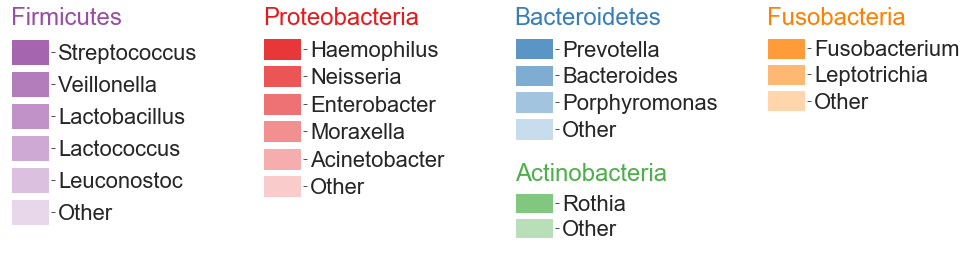

In [17]:
sns.set_style('white')
fig = plt.figure(figsize=(14, 4))

# 10 pixels per height of box, 4 pixels width, 22 between
h = 0.1
w = 0.04
btw = 0.21

l = 0.05
r = l + w
t = 0.85
b = t - 7*h

p = 'p__Firmicutes'
gs_firm = gridspec.GridSpec(1, 1, left=l, right=r, top=t, bottom=b)
ax_firm = plt.subplot(gs_firm[0])
plot_one_legend(p, ax_firm, phylodf, color_dict)


l = r + btw
r = l + w
b = t - 6*h
p = 'p__Proteobacteria'
gs_proteo = gridspec.GridSpec(1, 1, left=l, right=r, top=t, bottom=b)
ax_proteo = plt.subplot(gs_proteo[0])
plot_one_legend(p, ax_proteo, phylodf, color_dict)

l = r + btw
r = l + w
b = t - 4*h
p = 'p__Bacteroidetes'
gs_bacter = gridspec.GridSpec(1, 1, left=l, right=r, top=t, bottom=b)
ax_bacter = plt.subplot(gs_bacter[0])
plot_one_legend(p, ax_bacter, phylodf, color_dict)

t = b - btw/1.5
b = t - 2*h
p = 'p__Actinobacteria'
gs_actino = gridspec.GridSpec(1, 1, left=l, right=r, top=t, bottom=b)
ax_actino = plt.subplot(gs_actino[0])
plot_one_legend(p, ax_actino, phylodf, color_dict)

l = r + btw
r = l + w
t = 0.85
b = t - 3*h
p = 'p__Fusobacteria'
gs_fuso = gridspec.GridSpec(1, 1, left=l, right=r, top=t, bottom=b)
ax_fuso = plt.subplot(gs_fuso[0])
plot_one_legend(p, ax_fuso, phylodf, color_dict)

In [21]:
fig.savefig('../../final/figures/figure1.legend_all.png', dpi=200)
fig.savefig('../../final/figures/figure1.legend_all.pdf', dpi=200)

## Track samples

In [19]:
all_smpls = bal_asp + bal_nml + bal_nan \
    + gas_asp + gas_nml + gas_nan \
    + thr_asp + thr_nml + thr_nan

with open('../../data/patients/figure1.overview_plots.samples.txt', 'w') as f:
    f.write('\n'.join(all_smpls))